In [1]:
import os
import cv2
import json
import torch
import torchvision
import numpy as np
from torch import nn
from pathlib import Path
from itertools import product
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from utils import parse_panels, bbox_to_xyxy

# Contents of NPZ and XML files

In [2]:
npz = np.load('./in_distribute_four_out_center_single/RAVEN_0_train.npz')
for fn in npz.files:
    print(fn)
    print(npz[fn])
    print('-'*20)

image
[[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 ...

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255

In [3]:
tree = ET.parse('./in_distribute_four_out_center_single/RAVEN_0_train.xml')
root = tree.getroot()
all_panels = parse_panels(root)
pprint(all_panels)

[{'components': [{'component': {'id': '0', 'name': 'Out'},
                  'entities': [{'Angle': '0',
                                'Color': '0',
                                'Size': '3',
                                'Type': '3',
                                'bbox': '[0.5, 0.5, 1, 1]',
                                'mask': '[4071,1,4230,4,4235,1,4389,8,4548,11,4707,14,4866,16,4883,1,5025,20,5184,23,5343,25,5369,1,5502,29,5661,32,5820,36,5979,38,6138,41,6297,44,6456,46,6503,1,6615,50,6774,53,6933,55,6989,1,7092,59,7251,62,7410,65,7569,69,7728,72,7887,74,7962,1,8046,78,8205,81,8364,83,8523,86,8682,90,8841,91,9000,92,9159,92,9318,94,9477,94,9636,95,9795,95,9954,97,10113,98,10272,99,10431,99,10590,100,10749,101,10908,102,11067,103,11226,104,11387,102,11547,102,11708,102,11867,102,12028,101,12189,99,12349,99,12510,99,12670,99,12831,97,12992,96,13151,97,13312,96,13473,94,13633,94,13794,93,13955,92,14114,93,14275,91,14436,91,14596,90,14757,89,14917,90,15077,89,15238,88,15399,8

# Visualizing Images

In [5]:
all_panel_images = npz['image']
panel_idx = 0
all_panels_with_bbox_list = []
for p in all_panels:
    panel_image = all_panel_images[panel_idx,:,:].copy()
    for c in p['components']:
        for e in c['entities']:
            bbox = json.loads(e['real_bbox'])
            [x1, y1, x2, y2] = bbox_to_xyxy(bbox)
            cv2.rectangle(panel_image, (x1, y1), (x2, y2), (0,255,0), 3)
    all_panels_with_bbox_list.append(panel_image)
    panel_idx += 1
all_panels_with_bbox = np.stack(all_panels_with_bbox_list, axis=0)
all_panels_with_bbox.shape

(16, 160, 160)

In [6]:
def plot_example(panels: np.ndarray | list[np.ndarray], fig: plt.Figure | None = None):
    if not fig:
        fig = plt.figure(figsize=(8, 10))
    outer = gridspec.GridSpec(2, 1, height_ratios=[3, 2], wspace=0.2, hspace=0.2)
    # Context Panels
    inner = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[0], wspace=0.1, hspace=0.1)
    for i in range(0, 8):
        ax = plt.Subplot(fig, inner[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(cv2.cvtColor(panels[i], cv2.COLOR_BGR2RGB))
        fig.add_subplot(ax)
    
    # Candidate Panels
    inner = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=outer[1], wspace=0.1, hspace=0.1)
    for i in range(0, 8):
        ax = plt.Subplot(fig, inner[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(cv2.cvtColor(panels[8 + i], cv2.COLOR_BGR2RGB))
        fig.add_subplot(ax)
    return fig

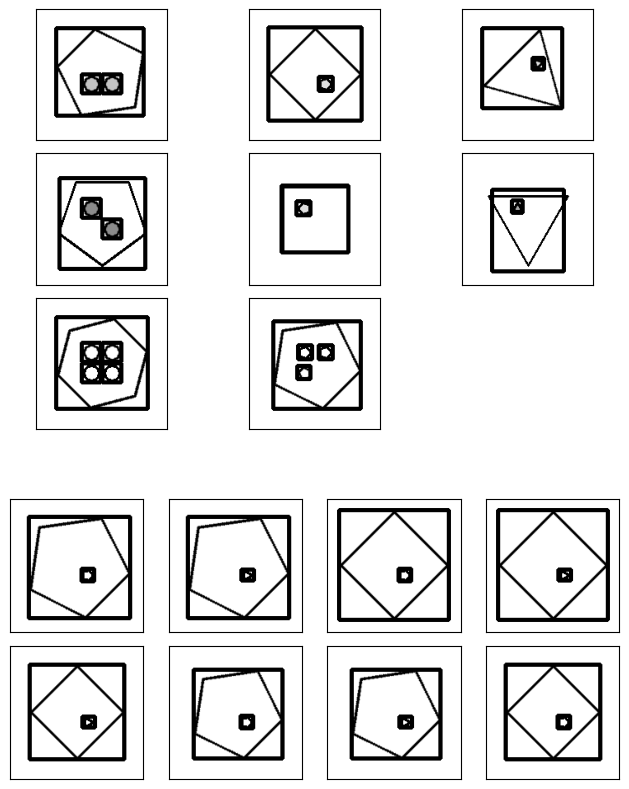

In [7]:
plot_example(all_panels_with_bbox)
plt.show()

# Building Dataset

In [39]:
class AVRDataset(Dataset):
    def __init__(
            self,
            dataset_dir: str,
            split: str = 'train',
            transform = None,
            target_transform = None):
        assert split in ['train', 'val', 'test']
        
        self.split = split
        self.configurations = [
            'center_single',
            'distribute_four',
            'distribute_nine',
            'in_center_single_out_center_single',
            'in_distribute_four_out_center_single',
            'left_center_single_right_center_single',
            'up_center_single_down_center_single'
        ]
        self.dataset_path = Path(dataset_dir)
        self.transform = transform
        self.target_transform = target_transform
        self.all_file_stems = list(fn.stem for fn in (self.dataset_path / Path(self.configurations[0])).glob(f'*_{self.split}.npz'))
        self.all_file_paths = [Path(self.dataset_path, config, base_fn) for config, base_fn in product(self.configurations, self.all_file_stems)]
        
        self.id2type = ['none', 'triangle', 'square', 'pentagon', 'hexagon', 'circle']
        self.id2size = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        self.id2color = [255, 224, 196, 168, 140, 112, 84, 56, 28, 0]
    
    def get_panel_by_id(self, idx: int):
        file_idx, panel_idx = int(idx / 16), int(idx % 16)
        return self.all_file_paths[file_idx], panel_idx
    
    def __len__(self):
        return len(self.all_file_paths) * 16
    
    def __getitem__(self, idx):
        file_path, panel_idx = self.get_panel_by_id(idx)
        
        npz = np.load(file_path.with_suffix('.npz'))
        image = torch.as_tensor(npz['image'][panel_idx, :, :], dtype=torch.float)
        image = torch.unsqueeze(image, dim=0)
        
        targets = {}
        boxes = []
        types = []
        sizes = []
        colors = []
        xml = ET.parse(file_path.with_suffix('.xml'))
        xml_root = xml.getroot()
        panel_info_list = parse_panels(xml_root)
        panel_info = panel_info_list[panel_idx]
        all_entities = []
        for component in panel_info['components']:
            all_entities += component['entities']
        for entity in all_entities:
            boxes.append(bbox_to_xyxy(json.loads(entity['real_bbox'])))
            types.append(int(entity['Type']))
            sizes.append(int(entity['Size']))
            colors.append(int(entity['Color']))
        
        targets['boxes'] = torch.as_tensor(boxes, dtype=torch.float)
        targets['types'] = torch.as_tensor(types, dtype=torch.int64)
        targets['labels'] = torch.as_tensor(types, dtype=torch.int64)
        targets['sizes'] = torch.as_tensor(sizes, dtype=torch.int64)
        targets['colors'] = torch.as_tensor(colors, dtype=torch.int64)
        targets['idx'] = torch.tensor(idx)
        # targets['image'] = image
        
        return image, targets

In [41]:
train_dataset = AVRDataset('./')
train_dataset[0]

(tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]]]),
 {'boxes': tensor([[ 38.,  38., 121., 121.]]),
  'types': tensor([5]),
  'labels': tensor([5]),
  'sizes': tensor([1]),
  'colors': tensor([5]),
  'idx': tensor(0)})

In [42]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Defining Model

In [43]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [44]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [56]:
num_classes = 6  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [58]:
images, targets = next(iter(train_data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(1, 160, 160), torch.rand(1, 160, 160)]
predictions = model(x)

In [49]:
len(targets)

2